In [1]:
import os
from pathlib import Path
from glob import glob


## Load image and Mask
Monai required the ditionary format to read and make some data augmentation. Minai use the same format as pytorch (C, H, W) so be care full we use librarie as opencv or PIL me sure to have the correct image format.

In [2]:
image_dir = "../data/test_images"
mask_dir = "../data/test_labels"

def transform_monai_format(image_dir, mask_dir):
    image_paths = sorted(glob(os.path.join(image_dir, "*")))
    mask_paths = sorted(glob(os.path.join(mask_dir, "*")))

    image_paths = [p.replace("\\", "/") for p in image_paths]
    mask_paths = [p.replace("\\", "/") for p in mask_paths]

    dict_files = [
        {"image": img, "label": msk}
        for img, msk in zip(image_paths, mask_paths)
    ]
    return dict_files

train_files = transform_monai_format(image_dir, mask_dir)
train_files[:2]

[{'image': '../data/test_images/image_121.tif',
  'label': '../data/test_labels/image_121.tif'},
 {'image': '../data/test_images/image_122.tif',
  'label': '../data/test_labels/image_122.tif'}]

## Data transformation

Somme important knowlage before about image formation:

* Blood vessels are mostly captured in the green channel.
* The red channel is often saturated and less informative.
* The blue channel is noisy and low-contrast.

| Channel | Vessel Contrast | Noise Level | Primary Use Case                                  |
| ------- | --------------- | ----------- | ------------------------------------------------- |
| Green   | Excellent       | Low         | Vessel segmentation, hemorrhages, microaneurysms. |
| Red     | Poor            | Very Low    | Detecting choroidal lesions or pigment changes.   |
| Blue    | Moderate/Poor   | High        | Visualizing the retinal nerve fiber layer (RNFL). |


The main transformation tha we need are:
* Clashe 
* Covert to grascale
* Somme geometrie tranformation 
* Duplicate tensor
* Tranform to pytorch format

In [3]:
import cv2
import numpy as np 
import torch
import tifffile

#img = tifffile.imread(train_files[0]['image'])  # shape: (D, H, W) or (H, W)

def wrapper_load_grayscale_tiff(color_idx = 1):
    def load_grayscale_tiff(path):
        # Load grayscale image with OpenCV
        img = np.array(cv2.imread(path, cv2.IMREAD_UNCHANGED))  # Read without change any thing
        if img is None:
            raise FileNotFoundError(f"File not found or unreadable: {path}")
        
        # Ensure 3 channels and back to RGB format and (C, H, W)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32).transpose(2, 0, 1) 

        if color_idx <= 2:
            img = img[color_idx, :, :]
            img = np.expand_dims(img, axis=0)
            
        return torch.from_numpy(img) 

    return load_grayscale_tiff


def repeat_channels(img):
    return np.repeat(img[np.newaxis, ...], 3, axis=0)


def apply_CLAHE(img):
    # img: Tensor or ndarray, shape (1, H, W)
    if isinstance(img, torch.Tensor):
        img_np = img.detach().cpu().numpy()
    else:
        img_np = img

    # Remove channel dim if present
    if img_np.ndim == 3:
        img_np = img_np[0]

    # Normalize to uint8 for CLAHE
    img_min, img_max = img_np.min(), img_np.max()
    img_np = (img_np - img_min) / (img_max - img_min + 1e-8)
    img_np = (img_np * 255).astype(np.uint8)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_np = clahe.apply(img_np)

    # Back to float32 normalized [0,1]
    img_np = img_np.astype(np.float32) / 255.0
    img_np = np.expand_dims(img_np, axis=0)  # Add channel dim

    return torch.from_numpy(img_np)

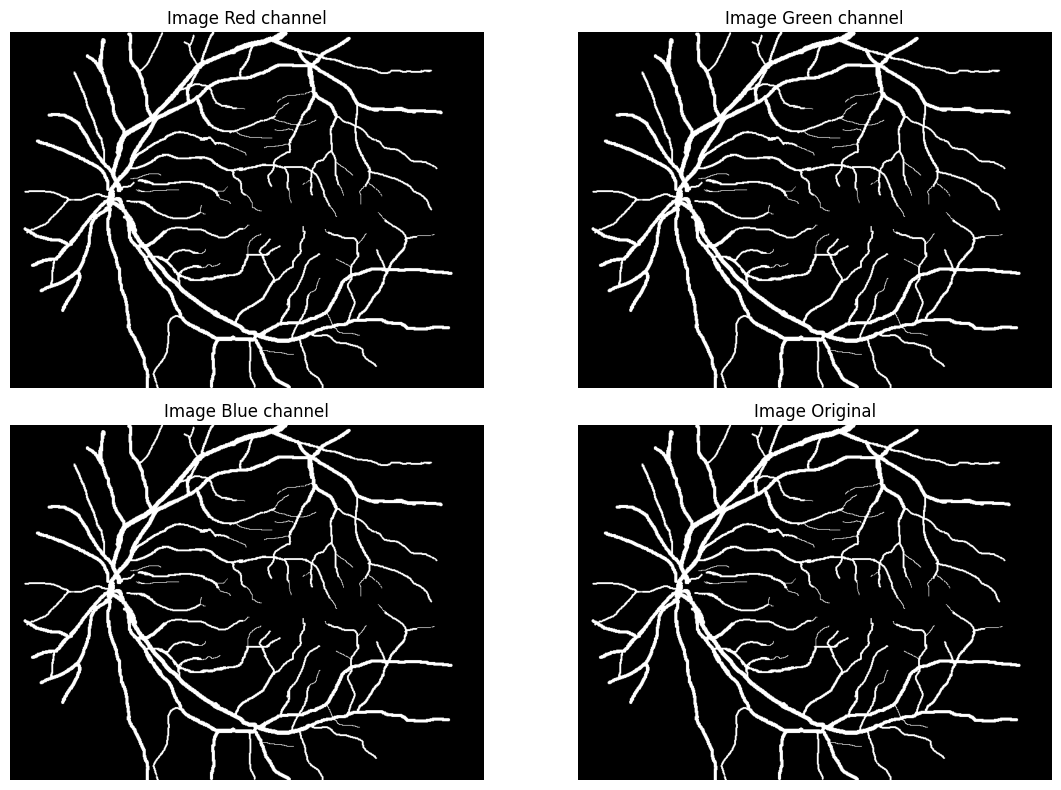

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns
axes = axes.flatten()  # flatten to 1D array for easy indexing

label_chanels = ['Red channel', 'Green channel', 'Blue channel', 'Original']
for idx, label_chanel in enumerate(label_chanels):
    # Load and preprocess the image
    retina_img = wrapper_load_grayscale_tiff(color_idx=idx)(train_files[2]['label'])
    if idx < 3:
        retina_img = apply_CLAHE(retina_img).squeeze()
    else:
        retina_img = retina_img.permute(1, 2, 0)  # (H, W, C)
        retina_img = retina_img / 255.0
    
    # Display in the appropriate subplot
    axes[idx].imshow(retina_img, cmap='gray')
    axes[idx].set_title(f'Image {label_chanel}')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [5]:
import torch

def repeat_channels_tensor(img):
    """
    @brief Repeat a single-channel torch tensor into 3 channels.

    This is useful for converting grayscale tensors of shape (H, W) or (1, H, W)
    into 3-channel tensors (3, H, W) for models expecting RGB input.

    @param img (torch.Tensor): Input tensor of shape (H, W) or (1, H, W).

    @return: torch.Tensor of shape (3, H, W) with repeated channels.
    """
    if img.ndim == 2:
        # Shape (H, W) -> (1, H, W)
        img = img.unsqueeze(0)
    elif img.ndim == 3 and img.shape[0] == 1:
        # Already (1, H, W), nothing to do
        pass
    else:
        raise ValueError(f"Expected tensor shape (H, W) or (1, H, W), got {img.shape}")

    # Repeat along channel axis
    return img.repeat(3, 1, 1)

In [6]:
from monai.transforms import (
    Compose, EnsureChannelFirstd, EnsureTyped,
    Resized, ScaleIntensityd, Lambdad
)

load_retina_img = wrapper_load_grayscale_tiff(color_idx = 1)
transforms_cacheable = Compose([
    Lambdad(keys=["image", "label"], func=load_retina_img),
    Lambdad(keys=["image"], func=apply_CLAHE),
    #EnsureChannelFirstd(keys=["image", "label"], channel_dim=-1), # (H, W) -> (1, H, W)
    Resized(keys=["image", "label"], spatial_size=(512, 512)),
    Lambdad(keys=["image"], func=repeat_channels_tensor),
    #ScaleIntensityd(keys=["image"]), # -> betwen [0, 1]
    EnsureTyped(keys=["image", "label"]),
])


d:\marchine_learning\Projet\Deep_learning Project\Segmentation\segmentatio_ICR\icr_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from monai.transforms import (
    RandFlipd, RandRotate90d, RandGaussianNoised, ToTensord
)

transforms_random = Compose([
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    RandRotate90d(keys=["image", "label"], prob=0.5),
    RandGaussianNoised(keys=["image"], prob=0.2, std=0.01),
    ToTensord(keys=["image", "label"]),
])


In [8]:
from monai.data import CacheDataset

train_ds = CacheDataset(
    data=train_files,
    transform=transforms_cacheable,
    cache_rate=1.0,      # tout mettre en cache
    num_workers=4
)

Loading dataset: 100%|██████████| 112/112 [00:16<00:00,  6.65it/s]


In [9]:
from monai.data import DataLoader

train_loader = DataLoader(
    train_ds,
    batch_size=16,
    shuffle=True,
    num_workers=0,
    collate_fn=lambda batch: transforms_random(batch)
)


In [10]:
for batch in train_loader:
    images = batch[1]["image"]
    labels = batch[1]["label"]
    break


## Create a class to wrapper all 


In [11]:
import sys
import os

sys.path.append(os.path.abspath(".."))
from src.dataset import ICRDataset

In [12]:
my_random_aug = Compose([
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    RandRotate90d(keys=["image", "label"], prob=0.5),
    RandGaussianNoised(keys=["image"], prob=0.2, std=0.01),
    ToTensord(keys=["image", "label"]),
])

dataset_builder = ICRDataset(
    image_dir="../data/test_images",
    mask_dir="../data/test_labels",
    channel=0,
    img_size=512,
    apply_repeat=True,
    apply_clahe=True,
    batch_size=16
)

dataset = dataset_builder.get_dataset()
train_loader = dataset_builder.get_dataloader(transforms_random=my_random_aug)

Loading dataset: 100%|██████████| 112/112 [00:28<00:00,  3.95it/s]
